In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# Import the Required Packages
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras import optimizers
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input


# import tensorflow as tf
# from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import visualkeras

# For plotting the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

import os
import datetime
import zipfile
import random

%matplotlib inline

print('tensorflow: ', tf.__version__)
print('keras: ', keras.__version__)

tensorflow:  2.10.1
keras:  2.10.0


In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
# path to your downloaded file
# base_dir = 'D:\\Practical\\DLIR\\Week_2\\cats_and_dogs_small\\'
base_dir = 'D:\\Users\\ng_a\\My NP SDGAI\\PDC-2\\DLIR\\HAR\\data\\'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [4]:
print (train_dir)
print (test_dir)

D:\Users\ng_a\My NP SDGAI\PDC-2\DLIR\HAR\data\train
D:\Users\ng_a\My NP SDGAI\PDC-2\DLIR\HAR\data\test


In [5]:
train_df = pd.read_csv(base_dir + "Training_set.csv")
test_df = pd.read_csv(base_dir + "Testing_set.csv")

In [6]:
num_classes = len(train_df.label.unique())

In [7]:
train_df.label.value_counts()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

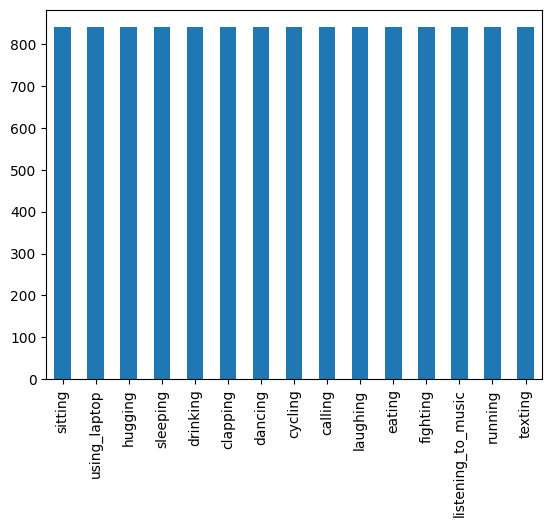

In [8]:
# https://www.statology.org/pandas-plot-value-counts/

# count plot on single categorical variable
train_df.label.value_counts()[train_df.label.unique()].plot(kind='bar')
 
# Show the plot
plt.show()

In [9]:
def plot_eval_curves(my_history, which_model):
    acc = my_history.history['accuracy']
    val_acc = my_history.history['val_accuracy']
    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']

    epochs_ = range(1,len(acc)+1)

    plt.plot(epochs_, acc, 'bo', label='Training acc')
    plt.plot(epochs_, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy' + ' - ' + which_model)
    plt.legend()
    
    filename_acc = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_train_val_accuracy.png')
    plt.savefig(filename_acc)
    
    plt.figure()

    plt.plot(epochs_, loss, 'bo', label='Training loss')
    plt.plot(epochs_, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss' + ' - ' + which_model)
    plt.legend()
    
    filename_loss = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_train_val_loss.png')
    plt.savefig(filename_loss) 
    
    plt.show()

In [10]:
def display_images():
    # Images from each class
    fig, axes = plt.subplots(3, 5, figsize=(20, 10))
    axes = axes.flatten()
    for idx, class_name in enumerate(train_df['label'].unique()):
        class_images = train_df[train_df['label'] == class_name]['filename'].values
        img = plt.imread(os.path.join(train_dir, class_images[0]))
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

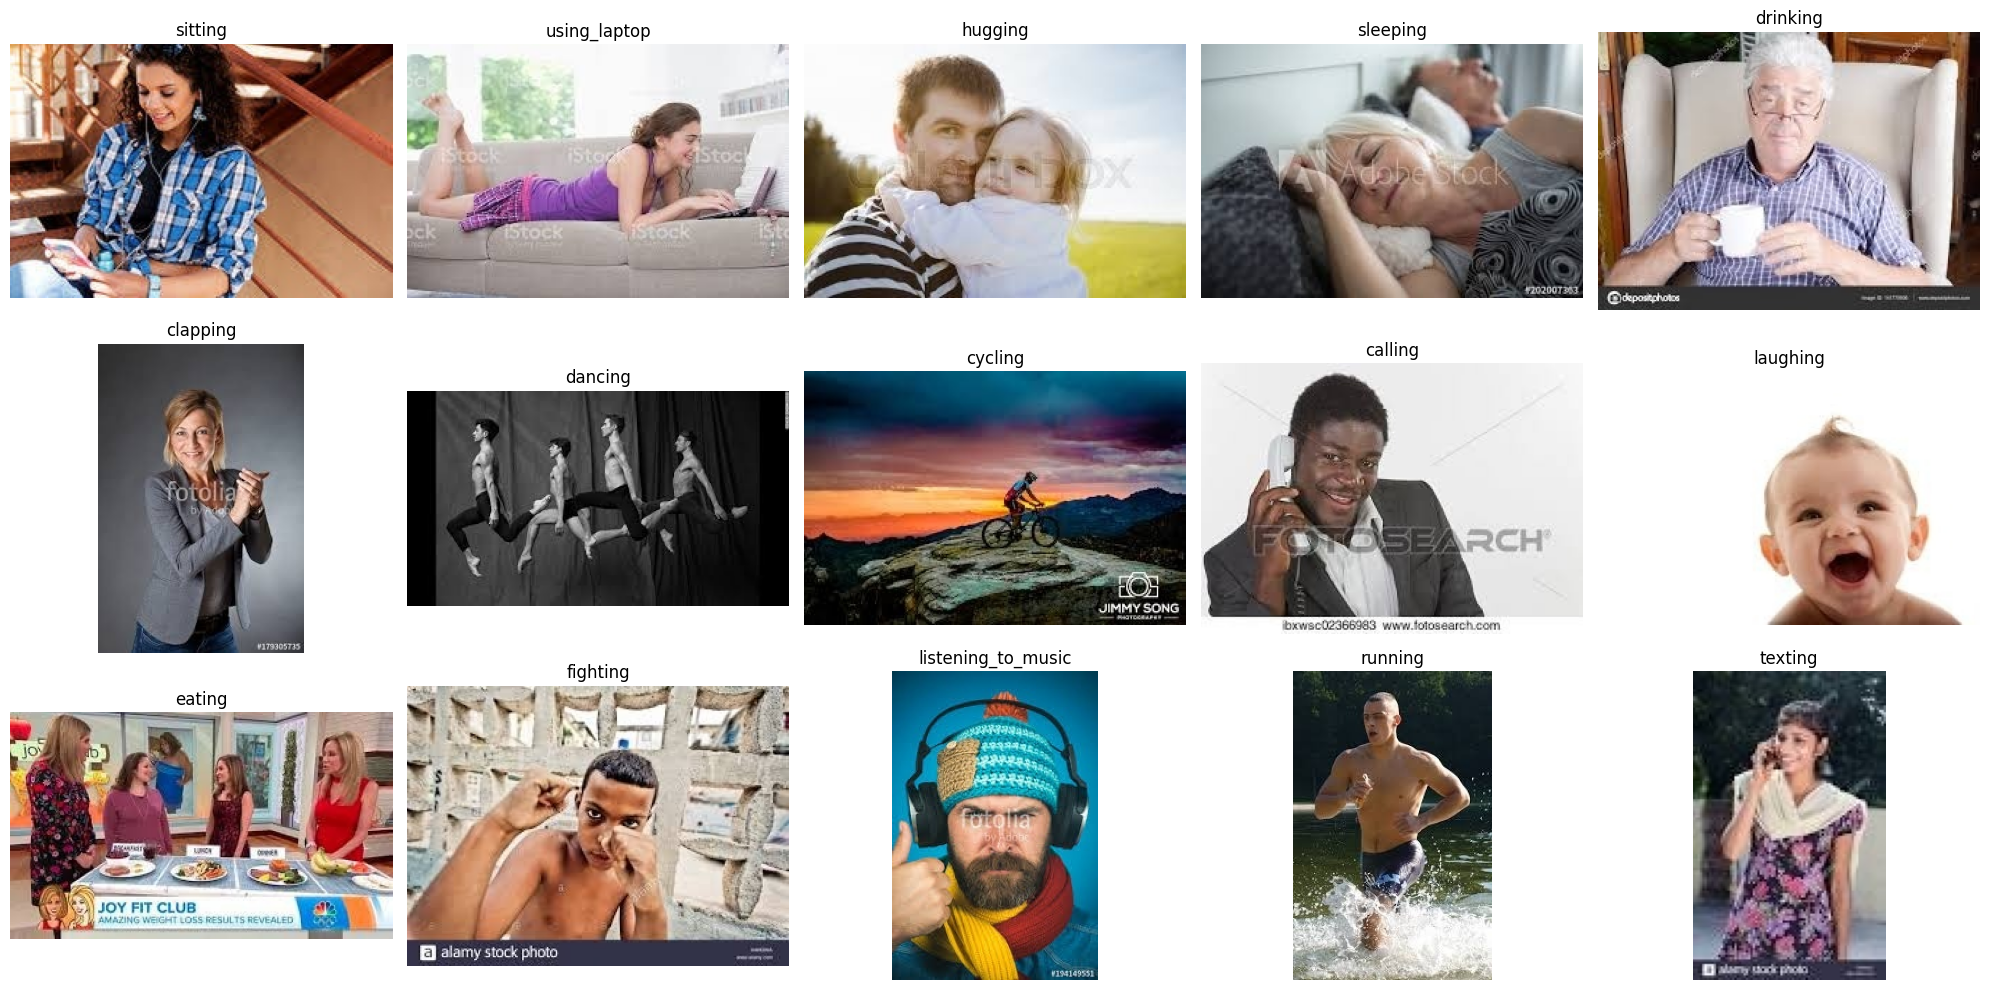

In [11]:
display_images()

In [12]:
# train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
# test_datagen_no_aug = ImageDataGenerator(rescale=1./255)

# train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
#         # This is the target directory
#         train_dir,
#         # All images will be resized to 150x150
#         target_size=(img_size, img_size),
#         batch_size=batch_size,
#         # For a multi-class classification problem
#         class_mode='categorical')

# test_generator_no_aug = test_datagen_no_aug.flow_from_directory(
#         test_dir,
#         target_size=(img_size, img_size),
#         batch_size=batch_size,
#         class_mode='categorical')

In [13]:
img_size = 128

In [14]:
# Preprocess images
def preprocess_image(img_path, target_size=(img_size, img_size)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    return img_array

In [15]:
def load_process_train_images(train_df):
    train_images = []
    train_labels = []

    for idx, row in train_df.iterrows():
        img_path = os.path.join(train_dir, row['filename'])
        img_array = preprocess_image(img_path)
        train_images.append(img_array)
        train_labels.append(row['label'])  
        
    return train_images, train_labels

In [16]:
def convert_2_array(train_df):
    
    train_images, train_labels = load_process_train_images(train_df)
    
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    # Convert labels to categorical (one-hot encoding)
    # train_labels = to_categorical(train_labels) 
    train_labels = to_categorical(np.asarray(train_df["label"].factorize()[0]))
    
    return train_images, train_labels

In [17]:
train_images, train_labels = convert_2_array(train_df)

# Split the training data
# train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Custom CNN Model

In [18]:
# We will resize all the images as 150*150 pixels
img_size = 128
batch_size = 64
# num_classes = 10
# epochs = 20
epochs = 30

In [19]:
model_1 = models.Sequential()

model_1.add(keras.Input(shape=(img_size, img_size, 3)))
model_1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(1024, activation='relu'))
model_1.add(layers.Dense(512, activation='relu'))
model_1.add(layers.Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [20]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy', # Used for multi-class classification
                metrics=['accuracy'])

In [21]:
history_1 = model_1.fit(X_train, y_train,
                      validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

Epoch 1/30
158/158 [==============================] - 10s 48ms/step - loss: 2.6021 - accuracy: 0.1158 - val_loss: 2.4016 - val_accuracy: 0.2008
Epoch 2/30
158/158 [==============================] - 7s 42ms/step - loss: 2.3684 - accuracy: 0.2170 - val_loss: 2.3450 - val_accuracy: 0.2341
Epoch 3/30
158/158 [==============================] - 7s 42ms/step - loss: 2.1476 - accuracy: 0.2923 - val_loss: 2.2150 - val_accuracy: 0.2925
Epoch 4/30
158/158 [==============================] - 7s 42ms/step - loss: 1.9521 - accuracy: 0.3599 - val_loss: 2.0694 - val_accuracy: 0.3345
Epoch 5/30
158/158 [==============================] - 7s 42ms/step - loss: 1.7248 - accuracy: 0.4388 - val_loss: 2.0524 - val_accuracy: 0.3528
Epoch 6/30
158/158 [==============================] - 7s 42ms/step - loss: 1.4189 - accuracy: 0.5431 - val_loss: 2.0823 - val_accuracy: 0.3643
Epoch 7/30
158/158 [==============================] - 7s 42ms/step - loss: 1.0174 - accuracy: 0.6656 - val_loss: 2.5107 - val_accuracy: 0.363

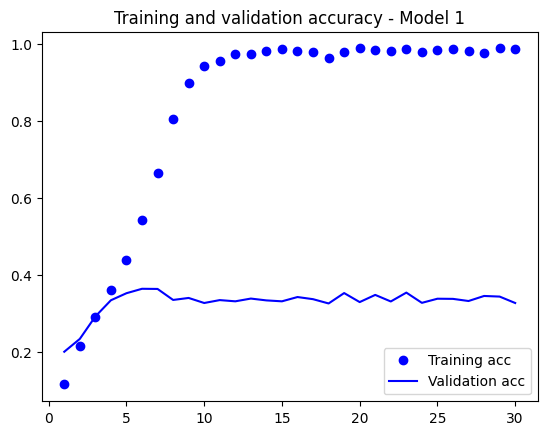

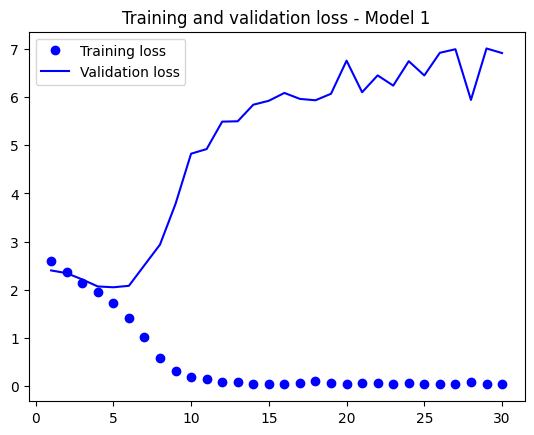

In [22]:
plot_eval_curves(history_1, "Model 1")

# Model 2

In [23]:
dnet_conv_base = DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))
dnet_conv_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 8, 8, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 8, 8, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 8, 8, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 4, 4, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 4, 4, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

In [24]:
model_2 = models.Sequential()

# to prevent any adjustment to the pre-trained weights of vgg16
dnet_conv_base.trainable = False

model_2.add(dnet_conv_base)

# load in the layers found in vgg16
for layer in dnet_conv_base.layers:
    # print (layer.name)
    layer.trainable = False
    # model_2.add(layer)
    
model_2.add(layers.Flatten())
model_2.add(layers.Dense(1024, activation='relu'))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(num_classes, activation='softmax'))

In [25]:
# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train the model on the training data
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/30
158/158 [==============================] - 28s 132ms/step - loss: 3.0129 - accuracy: 0.4749 - val_loss: 1.4271 - val_accuracy: 0.5476
Epoch 2/30
158/158 [==============================] - 16s 102ms/step - loss: 1.0887 - accuracy: 0.6466 - val_loss: 1.3527 - val_accuracy: 0.5817
Epoch 3/30
158/158 [==============================] - 16s 102ms/step - loss: 0.8303 - accuracy: 0.7280 - val_loss: 1.4210 - val_accuracy: 0.5639
Epoch 4/30
158/158 [==============================] - 16s 102ms/step - loss: 0.6401 - accuracy: 0.7905 - val_loss: 1.5325 - val_accuracy: 0.5615
Epoch 5/30
158/158 [==============================] - 16s 102ms/step - loss: 0.4858 - accuracy: 0.8407 - val_loss: 1.5898 - val_accuracy: 0.5845
Epoch 6/30
158/158 [==============================] - 16s 103ms/step - loss: 0.3376 - accuracy: 0.8868 - val_loss: 1.6188 - val_accuracy: 0.5988
Epoch 7/30
158/158 [==============================] - 16s 103ms/step - loss: 0.2325 - accuracy: 0.9226 - val_loss: 1.9611 - val_ac

In [27]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              16778240  
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 15)                7695      
                                                                 
Total params: 24,348,239
Trainable params: 17,310,735
Non-trainable params: 7,037,504
_________________________________________________________________


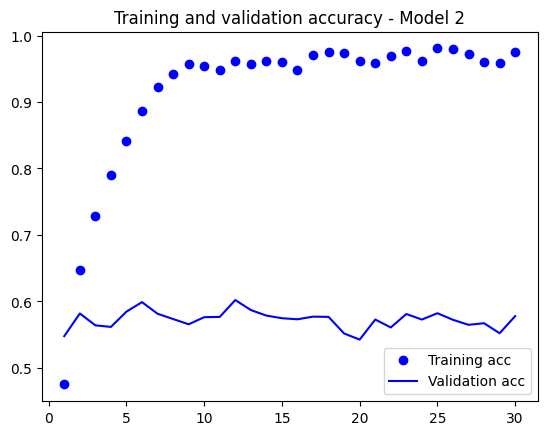

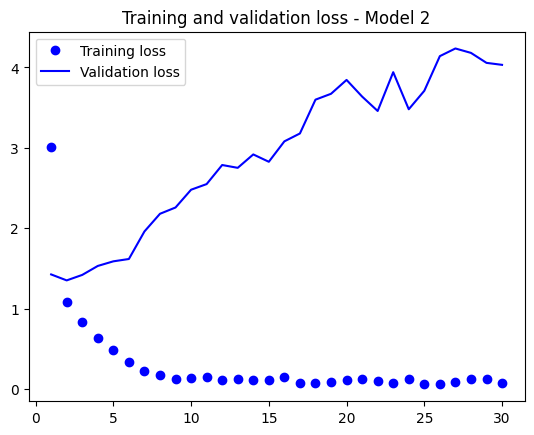

In [29]:
plot_eval_curves(history_2, "Model 2")

# Model 3

In [30]:
dnet_conv_base_2 = DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))
dnet_conv_base_2.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                        

 conv2_block4_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 16, 16, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 8, 8, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 8, 8, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 8, 8, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 8, 8, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_poo

 conv5_block4_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_blo

In [31]:
model_3 = models.Sequential()

# to prevent any adjustment to the pre-trained weights of vgg16
dnet_conv_base_2.trainable = False

model_3.add(dnet_conv_base_2)

# load in the layers found in vgg16
# for layer in dnet_conv_base.layers:
#     # print (layer.name)
#     layer.trainable = False
    # model_2.add(layer)
    
set_trainable = False
for layer in dnet_conv_base_2.layers:
    if layer.name == 'conv5_block16_2_conv':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False    
    
model_3.add(layers.Flatten())
model_3.add(layers.Dense(1024, activation='relu'))
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(num_classes, activation='softmax'))

In [32]:
# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Preprocess images function
# def preprocess_image_4_tl(img_path, target_size=(img_size, img_size)):
#     img = load_img(img_path, target_size=target_size)
#     img_array = img_to_array(img)
#     img_array = preprocess_input(img_array)  # Apply preprocess_input from DenseNet121
#     return img_array
                          
# def load_process_train_images_4_tl(train_df):
#     train_images = []
#     train_labels = []

#     for idx, row in train_df.iterrows():
#         img_path = os.path.join(train_dir, row['filename'])
#         img_array = preprocess_image_4_tl(img_path)
#         train_images.append(img_array)
#         train_labels.append(row['label'])  
        
#     return train_images, train_labels  

# def convert_2_array_4_tl(train_df):
    
#     train_images, train_labels = load_process_train_images_4_tl(train_df)
    
#     train_images = np.array(train_images)
#     train_labels = np.array(train_labels)

#     # Convert labels to categorical (one-hot encoding)
#     # train_labels = to_categorical(train_labels) 
#     train_labels = to_categorical(np.asarray(train_df["label"].factorize()[0]))
    
#     return train_images, train_labels  

In [ ]:
# train_images_1, train_labels_1 = convert_2_array_4_tl(train_df)
# X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train_images_1, train_labels_1, test_size=0.2, random_state=42)

In [33]:
history_3 = model_3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/30
158/158 [==============================] - 22s 110ms/step - loss: 2.3965 - accuracy: 0.4700 - val_loss: 1.4256 - val_accuracy: 0.5595
Epoch 2/30
158/158 [==============================] - 15s 97ms/step - loss: 1.0830 - accuracy: 0.6483 - val_loss: 1.3721 - val_accuracy: 0.5726
Epoch 3/30
158/158 [==============================] - 16s 99ms/step - loss: 0.8142 - accuracy: 0.7302 - val_loss: 1.4096 - val_accuracy: 0.5853
Epoch 4/30
158/158 [==============================] - 15s 93ms/step - loss: 0.6102 - accuracy: 0.7996 - val_loss: 1.4131 - val_accuracy: 0.5948
Epoch 5/30
158/158 [==============================] - 15s 96ms/step - loss: 0.4351 - accuracy: 0.8540 - val_loss: 1.6690 - val_accuracy: 0.5766
Epoch 6/30
158/158 [==============================] - 15s 97ms/step - loss: 0.3046 - accuracy: 0.8979 - val_loss: 1.7659 - val_accuracy: 0.5940
Epoch 7/30
158/158 [==============================] - 15s 97ms/step - loss: 0.2271 - accuracy: 0.9221 - val_loss: 1.8471 - val_accuracy

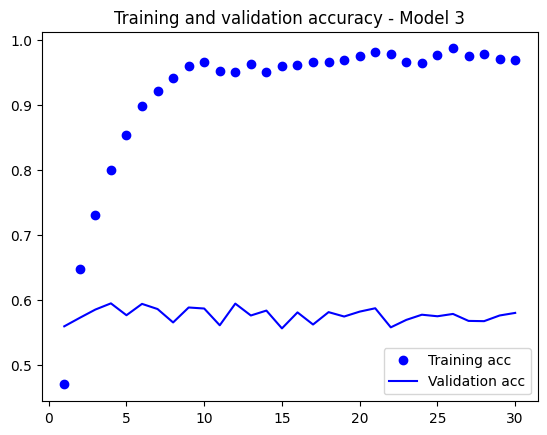

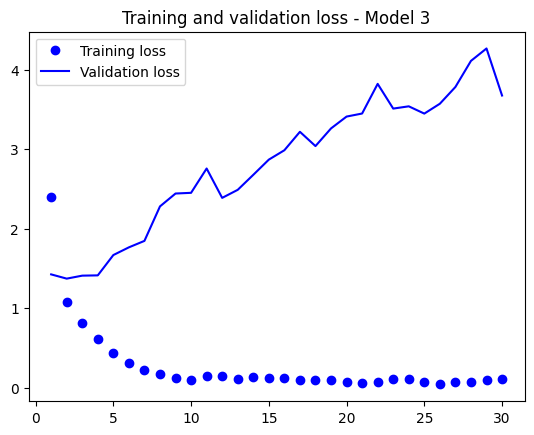

In [40]:
plot_eval_curves(history_3, "Model 3")

# Model 4

In [37]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Paths to your directories and CSV file
# train_dir = 'path/to/train'
# csv_file = 'path/to/labels.csv'

# # Load the CSV file
# labels_df = pd.read_csv(csv_file)

# Create an ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data into training and validation sets
)

# Load and augment images from the dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Load the pre-trained DenseNet121 model excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model and add the DenseNet121 base model
model_4 = models.Sequential()
model_4.add(base_model)

# Add custom layers on top of the base model
model_4.add(GlobalAveragePooling2D())
model_4.add(Dense(1024, activation='relu'))
model_4.add(Dense(num_classes, activation='softmax'))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_4.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the augmented data
history_4 = model_4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)]
)

# Unfreeze some layers of the base model and continue training (fine-tuning)
# for layer in base_model.layers:
#     layer.trainable = True

# # Compile the model again with a lower learning rate for fine-tuning
# model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# # Continue training the model
# history_fine = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=10,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1),
#                ModelCheckpoint('best_model_fine_tuned.h5', monitor='val_loss', save_best_only=True, verbose=1)]
# )


Found 10080 validated image filenames belonging to 15 classes.
Found 2520 validated image filenames belonging to 15 classes.
Epoch 1/10
315/315 [==============================] - 188s 576ms/step - loss: 1.5134 - accuracy: 0.5173 - val_loss: 1.2943 - val_accuracy: 0.5778
Epoch 2/10
315/315 [==============================] - 118s 374ms/step - loss: 1.2347 - accuracy: 0.5984 - val_loss: 1.2886 - val_accuracy: 0.5861
Epoch 3/10
315/315 [==============================] - 116s 369ms/step - loss: 1.1503 - accuracy: 0.6281 - val_loss: 1.2219 - val_accuracy: 0.6024
Epoch 4/10
315/315 [==============================] - 119s 376ms/step - loss: 1.1076 - accuracy: 0.6382 - val_loss: 1.2771 - val_accuracy: 0.5841
Epoch 5/10
315/315 [==============================] - 122s 388ms/step - loss: 1.0690 - accuracy: 0.6425 - val_loss: 1.1508 - val_accuracy: 0.6310
Epoch 6/10
315/315 [==============================] - 118s 376ms/step - loss: 1.0290 - accuracy: 0.6643 - val_loss: 1.1835 - val_accuracy: 0.6048

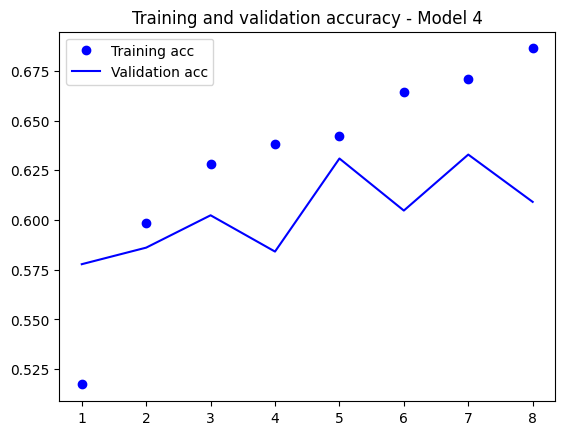

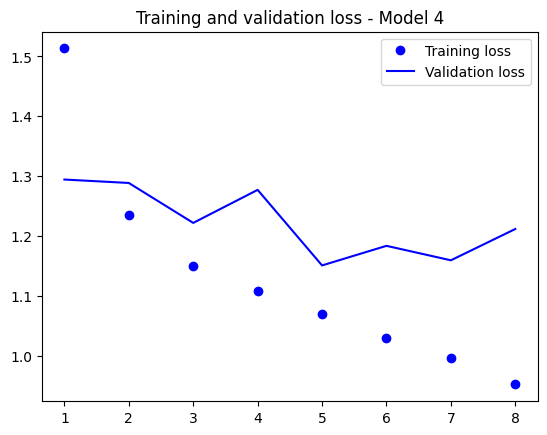

In [41]:
plot_eval_curves(history_4, "Model 4")

In [39]:
# Create a Sequential model and add the DenseNet121 base model
model_5 = models.Sequential()
model_5.add(base_model)

# Add custom layers on top of the base model
model_5.add(GlobalAveragePooling2D())
model_5.add(Dense(1024, activation='relu'))
model_5.add(Dense(num_classes, activation='softmax'))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze only the last few layers of the base model
# for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
#     layer.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block16_2_conv':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

# Compile the model again with a lower learning rate for fine-tuning
model_5.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model_5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)]
)

Epoch 1/30
315/315 [==============================] - 114s 347ms/step - loss: 2.4739 - accuracy: 0.2188 - val_loss: 2.1676 - val_accuracy: 0.3484
Epoch 2/30
315/315 [==============================] - 114s 362ms/step - loss: 2.0041 - accuracy: 0.4031 - val_loss: 1.8290 - val_accuracy: 0.4504
Epoch 3/30
315/315 [==============================] - 116s 367ms/step - loss: 1.7486 - accuracy: 0.4830 - val_loss: 1.6481 - val_accuracy: 0.4996
Epoch 4/30
315/315 [==============================] - 118s 373ms/step - loss: 1.5957 - accuracy: 0.5208 - val_loss: 1.5324 - val_accuracy: 0.5230
Epoch 5/30
315/315 [==============================] - 119s 376ms/step - loss: 1.4883 - accuracy: 0.5464 - val_loss: 1.4501 - val_accuracy: 0.5595
Epoch 6/30
315/315 [==============================] - 119s 377ms/step - loss: 1.4204 - accuracy: 0.5580 - val_loss: 1.4018 - val_accuracy: 0.5643
Epoch 7/30
315/315 [==============================] - 119s 376ms/step - loss: 1.3822 - accuracy: 0.5706 - val_loss: 1.3506 -

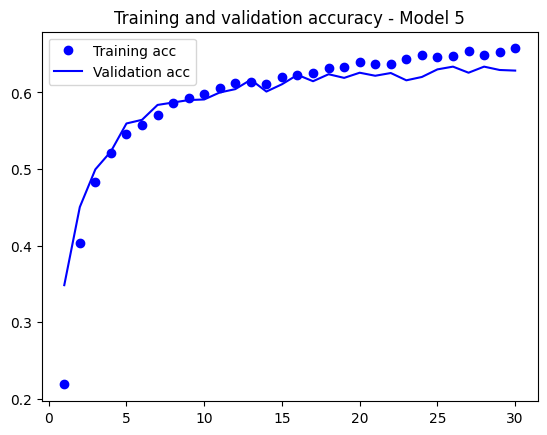

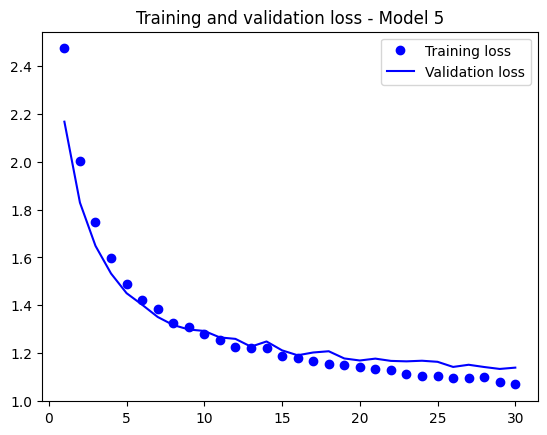

In [43]:
plot_eval_curves(history_fine, "Model 5")

# Dataset

https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset

In [ ]:
images = []
labels = []
for index, row in train_data.iterrows():
    # print(row['filename'], row['label'])
    img = image.load_img(train_dir + '\\' + row['filename'], target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    images.append(img_array)
    labels.append(row['label'])

In [ ]:
from PIL import Image

images = []
labels = []

for i in range(train_df.shape[0]):
    t = train_dir + '\\' + train_df['filename'][i]    
    temp_img = Image.open(t)
    images.append(np.asarray(temp_img.resize((img_size,img_size))))
    labels.append(train_df['label'][i])

In [ ]:
y_train = to_categorical(np.asarray(train_data["label"].factorize()[0]))
print(y_train[0])

In [ ]:
print (y_train)

In [ ]:
train_images, train_labels = convert_2_array(train_df)

# Split the training data
# train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
train_images_1, train_labels_1 = convert_2_array_4_tl(train_df)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train_images_1, train_labels_1, test_size=0.2, random_state=42)